# Model Building

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

drive_dir = "/content/drive/My Drive"
mount_dir = os.path.join(drive_dir, "Colab Notebooks")
base_dir = os.getcwd()
data_dir = os.path.join(drive_dir, "Test Data/RadiomicFeatures.csv")

Mounted at /content/drive


## 1. Data Preproccesing

In [5]:
# load data set
features_data = pd.read_csv(data_dir)
features_data.head()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance
0,0.527583,0.513377,57.283694,111.582079,114.212590,115.152790,73.284082,122.643745,237540.783691,58.868845,...,17.019354,0.011378,489.785185,0.403115,0.658978,136.257830,0.007516,6.080010,0.180107,3255.880190
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.521267,0.446565,45.221860,101.266101,113.592903,100.020486,60.776486,113.771650,164111.006592,52.786691,...,39.427170,0.014237,1231.206019,0.382006,0.641698,130.008726,0.007626,6.319431,0.143800,10372.099039
3,0.565475,0.449311,46.427784,103.331131,113.553247,112.623081,68.007353,115.767666,194060.038535,58.431183,...,26.608202,0.020693,1239.888344,0.433983,0.685239,89.661381,0.013659,5.961805,0.161058,5504.858331
4,0.485448,0.407476,42.413620,104.088690,111.060812,106.570473,58.235949,111.219413,154694.140625,50.529691,...,13.131031,0.015890,1038.289971,0.377286,0.636561,129.422304,0.008716,6.460849,0.150145,4201.871850


In [6]:
# create outcome variable
HCC = np.concatenate((np.zeros(20), np.ones(20)), axis=0)
features_data['HCC'] = HCC.tolist()

# create id variable
id = np.array(range(1, 41))
features_data['id'] = id.tolist()

In [7]:
# create feature only dataset
features_only = features_data.drop(['HCC','id'], axis=1)

# remove rows with all 0s
features_only = features_only.loc[~(features_only==0).all(axis=1)]
features_only.shape # 34 rows remaining

(34, 72)

In [8]:
# remove constant features
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(features_only)
constant_columns = [column for column in features_only.columns
                    if column not in features_only.columns[constant_filter.get_support()]]
features_only.drop(labels=constant_columns, axis=1, inplace=True)
features_only.shape

(34, 72)

In [9]:
# remove quasi constant features
qconstant_filter = VarianceThreshold(threshold=0.001)
qconstant_filter.fit(features_only)
qconstant_columns = [column for column in features_only.columns
                     if column not in features_only.columns[qconstant_filter.get_support()]]
features_only.drop(labels=qconstant_columns, axis=1, inplace=True)
features_only.shape

(34, 64)

In [10]:
# get column names
features_names = list(features_only.columns)
len(features_names)

64

In [11]:
# z-score standardize predictors
scaler = StandardScaler()
features_only = scaler.fit_transform(features_only)

In [12]:
# drop missing columns from full dataset
features_only = pd.DataFrame(features_only, columns=features_names)
features_data = features_data[features_names]

# drop missing observations from full dataset
features_data = pd.merge(features_data, features_only, how='right', indicator=True).drop('_merge', axis=1)
features_data.shape

(34, 64)

In [13]:
HCC = np.concatenate((np.zeros(14), np.ones(20)), axis=0)
features_data['HCC'] = HCC.tolist()

In [18]:
len(features_data.columns)

65

In [59]:
# remove correlated features
def corrX(df, outcome, cut = 0.8) :

    # create storage space
    bi_corr = np.zeros((len(df.columns),2))
    df_notarget = df.drop(['HCC'], axis=1)
    drop = list()
        
    # get correlation matrix and upper triagle
    corr_mtx = df_notarget.corr().abs()
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
  
    # get point biserial correlation with outcome variable
    for idx, column in enumerate(df.columns):
      bi_corr[idx] = stats.pointbiserialr(df[column], df['HCC'])
    
    # drop column with p-values
    bi_corr = np.delete(bi_corr, -1, axis=1)

		# loop over correlation matrix and remove features 
    # based on point-biserial correlation with outcome
    for row in range(len(up)-1):
      col_idx = row + 1
      for col in range (col_idx, len(up)):
        if(corr_mtx.iloc[row, col] > cut):
          if(bi_corr[row] > bi_corr[col]): 
            drop.append(row)
          else: 
            drop.append(col)
    
    drop_set = list(set(drop))
    dropcols_names = list(df.columns[[item for item in drop_set]])
    
    return(dropcols_names)

In [61]:
drop_features = corrX(features_data, HCC)
features_data = features_data.drop(drop_features, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


In [66]:
features_only = features_data.drop(['HCC'], axis=1)
features_names = list(features_only.columns)

## 2. Exploratory Analysis

In [62]:
correlations = features_only.corr()
dissimilarity = 1 - abs(correlations)
Z = linkage(squareform(dissimilarity), 'complete')

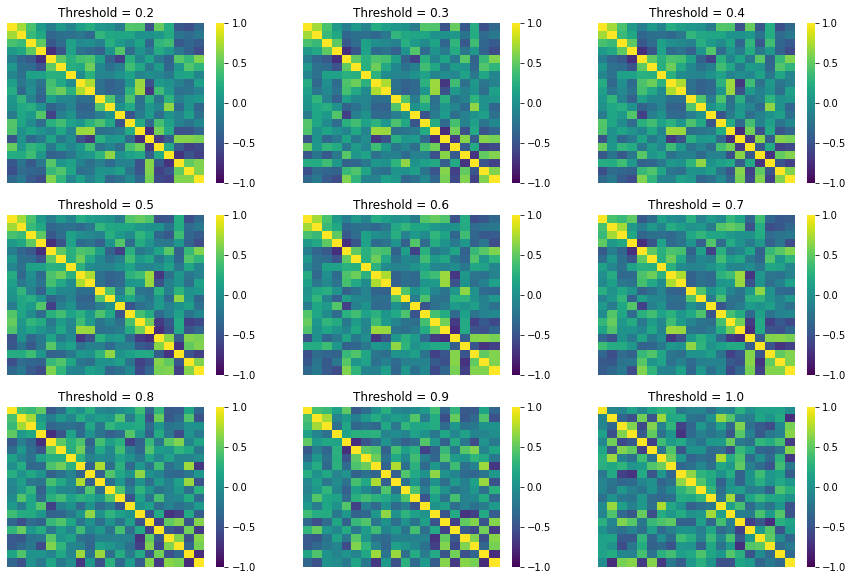

In [63]:
plt.figure(figsize=(15,10))

for idx, threshold in enumerate(np.arange(0.2,1.1,0.1)):
    
    # Subplot idx + 1
    plt.subplot(3, 3, idx+1)
    
    # Calculate the cluster
    labels = fcluster(Z, threshold, criterion='distance')

    # Keep the indices to sort labels
    labels_order = np.argsort(labels)

    # Build a new dataframe with the sorted columns
    for idx, i in enumerate(features_data.columns[labels_order]):
        if idx == 0:
            clustered = pd.DataFrame(features_data[i])
        else:
            df_to_append = pd.DataFrame(features_data[i])
            clustered = pd.concat([clustered, df_to_append], axis=1)
            
    # Plot the correlation heatmap
    correlations = clustered.corr()
    sns.heatmap(round(correlations,2), cmap='viridis', vmin=-1, vmax=1, 
                xticklabels=False, yticklabels=False)
    plt.title("Threshold = {}".format(round(threshold,2)))


## 3. Model Building

### 3.1 Using sklearn

In [67]:
# divide data set in 75%:25% split
X = features_data[features_names] # Features
y = features_data['HCC'] # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

In [68]:
# fit logistic regression model and obtain predicted values
model = LogisticRegression(random_state=16)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [69]:
# get coefficients and p-values
print(model.coef_, model.intercept_)

[[-0.77875644 -0.35140221  0.06901906  0.08387332 -0.5426067   0.29548198
  -0.36780326  0.80975196 -0.00779194 -0.16909206 -0.08689248 -0.74278803
  -0.163831    0.22402317  0.36492914  0.58240487  0.24684361  0.76569502
  -0.76315527  0.76133611]] [0.73103736]


In [70]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[4, 0],
       [0, 5]])

In [71]:
from sklearn.metrics import classification_report
labels = ['no HCC', 'HCC']
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

      no HCC       1.00      1.00      1.00         4
         HCC       1.00      1.00      1.00         5

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



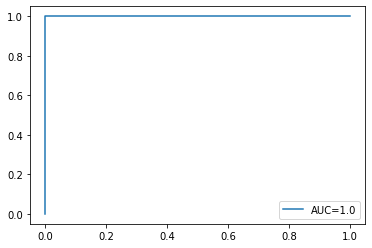

In [72]:
# plot ROC-curve
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

### 3.2 Using statsmodel

In [74]:
import statsmodels.api as sm

model = sm.GLM(y_train, sm.add_constant(X_train), family=sm.families.Binomial())
results = model.fit()
results.summary2()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


PerfectSeparationError: ignored